In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#default_exp learner

# Learner

Leaner to train the model

In [ ]:
#export 
from torch.optim.lr_scheduler import _LRScheduler


import copy

from PrimeCNNv3.imports import *
from PrimeCNNv3.utils.vizualize import plot_lr


In [ ]:
#export
class Learner:
    def __init__(self, model, dls, metric, cbs, loss_func, opt_func = None, lr_schedular_func = None):
        self.model = model
        self.dls = dls
        self.device = torch.device(dls.device)
        self.metric = metric
        self.cbs = cbs
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.lr_schedular_func = lr_schedular_func
        
        self.opt = None
        self.lr_schedular = None
        
        #get the number of layer groups in the model
        self.layer_groups = len([*self.model.children()])
        
        for cb in self.cbs:
            cb.learner = self
        
    
    def lr_finder(self, final_lr = 10, start_lr = 1e-08,num_iter = 100, wd = 0, beta = 0.98, suggestion = True):
        
        #save model, optimizer and lr_schdeular
        saved_param = {
            'model' : copy.deepcopy(self.model.state_dict()),
            'optimizer' : copy.deepcopy(self.opt.state_dict()) if self.opt is not None else None,
            'lr_schedular' : copy.deepcopy(self.lr_schedular if self.lr_schedular is not None else None)
        }
        store_cbs = self.cbs
        self.cbs = []
        avg_loss = 0.
        best_loss = 0.
        
        lrs = []
        lr_loss = []
        self.num_iter = num_iter
        self.model.to(self.device)
        self.training = True
    
        self._init_optimizer(epochs = None, lr= start_lr, wd = wd)
        self.lr_schedular = ExponentialLR(self.opt,final_lr= final_lr, num_iter= self.num_iter)
        
        for self.num in  progress_bar(range(self.num_iter), leave = False):
            xb,yb = iter(self.dls.train).next()
            self.xb = xb.to(self.device, non_blocking = True)
            self.yb = yb.to(self.device, non_blocking = True)
            
            #do one batch
            self.do_batch()
            
            #take moving average
            avg_loss = avg_loss * beta + (1-beta) * self.running_loss
            smooth_loss = avg_loss / (1 - beta**(self.num + 1))
            
            if self.num + 1 > 1 and smooth_loss > 4 * best_loss:
                print('Loss exploding.. stopping training')
                break
            
            if smooth_loss < best_loss or self.num + 1 == 1:
                best_loss = smooth_loss
                
            #refactor later
            lr_loss.append(smooth_loss)
            lrs.append(self.lr_schedular.get_last_lr())
        
        if suggestion:
            lr_s, losses = torch.tensor(lrs[num_iter // 10 : -5]), torch.tensor(lr_loss[num_iter // 10 :-5])
            if not (len(losses) == 0):
                lr_min = lr_s[losses.argmin()].item()
                grad = (losses[1:] - losses[:-1]) / (lr_s[1:].log() - lr_s[:-1].log())
                
                lr_steep = lr_s[grad.argmin()].item()
                
                print(f'Suggested LR : \nmin_lr: {lr_min / 10} \nlr_steep: {lr_steep}' )
            else:
                print(f'Length of Loss is zero, NO suggestion')
        
        plot_lr(lrs, lr_loss)
        
        self.cbs = store_cbs
        self.model.load_state_dict(saved_param['model'])
        self.xb, self.yb = None, None
        if saved_param['optimizer'] is None:
            self.opt = None
        else:
            self.opt.load_state_dict(saved_param['optimizer'])
        
        if saved_param['lr_schedular'] is None:
            self.lr_schedular = None
        else:
            self.lr_schedular = saved_param['lr_schedular']
            
        
    
    def do_batch(self):
        self('before_batch')
        self.batch_size = len(self.yb)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        self.running_loss = self.loss.item()
        
        if self.training:
            self.opt.zero_grad()
            self.loss.backward()
            self.opt.step()
            
            if self.lr_schedular is not None:
                self.lr_schedular.step()
                
        self('after_batch')
      
    
    def do_valid_epoch(self):
        self('before_valid_epoch')
    
        dl = self.dls.valid
        
        for self.num, self.batch in enumerate(progress_bar(dl, parent= self.mb)):
            with torch.no_grad():
                self.do_batch()
                
        self('after_valid_epoch')
   
    def do_train_epoch(self):
        self('before_train_epoch')
        
        dl = self.dls.train
        for self.num, self.batch in enumerate(progress_bar(dl, parent= self.mb)):
            self.do_batch()
            
        self('after_train_epoch')
    
    
    def fit(self, epochs, lr, wd, **kwargs):
        
        
        self._init_optimizer(epochs, lr, wd, **kwargs)
        
        #if self.lr_schedular_func is not None:
            #only for one cycle (Note: can be set at before_fit callback)
           # self.lr_schedular = torch.optim.lr_scheduler.OneCycleLR(self.opt, max_lr = lr, epochs = epochs,
                                                                #steps_per_epoch = len(self.dls.train))
        self('before_fit')
        try:
          
            for self.epoch in self.mb:
                self('before_epoch')
                self.do_train_epoch()
                self.do_valid_epoch()
                self('after_epoch')

        except FitCancelException: pass
        
        self('after_fit')
    
    def one_cycle_fit(self, epochs, max_lr, wd, div_factor = 25., pct_start= 0.25, **kwargs):
        
    
        self._init_optimizer(epochs, max_lr, wd, **kwargs)
        
        
        
        self.lr_schedular = torch.optim.lr_scheduler.OneCycleLR(self.opt, max_lr = max_lr, epochs = epochs,
                                                                steps_per_epoch = len(self.dls.train), div_factor= div_factor,
                                                           pct_start = pct_start)
        self('before_fit')
        try:
            
            for self.epoch in self.mb:
                self('before_epoch')
                self.do_train_epoch()
                self.do_valid_epoch()
                self('after_epoch')
  
        except FitCancelException: pass
        
       
        
        self('after_fit')
    
    def _init_optimizer(self, epochs, lr, wd, **kwargs):
        self.epochs = epochs
        self.lr = lr
        self.wd = wd
        
        self.opt = self.opt_func(params = filter(lambda p: p.requires_grad, self.model.parameters()), lr = self.lr,
                                weight_decay = self.wd,eps = 1e-05, betas = (0.9,0.99), **kwargs)
    
    def freeze_to(self, freeze_to_till):
        '''
            change require grad to false i.e freeze the layers
        '''
        if freeze_to_till < self.layer_groups or freeze_to_till > -self.layer_groups:

            freeze_to_till = freeze_to_till if freeze_to_till >= 0 else (self.layer_groups) + freeze_to_till

            for idx, layer in enumerate(self.model.children()):
                if idx >= freeze_to_till:
                    print(f'Layer :{idx} unFreeze')
                    for param in layer.parameters():
                        param.require_grad = True

                else:
                    print(f'Layer :{idx} Freeze')
                    for param in layer.parameters():
                        param.require_grad = False
                        
    def freeze(self):
        '''
            Freeze last group of layers (in this case classifier)
        '''
        self.freeze_to(freeze_to_till=-1)
        
    def unfreeze(self):
        self.freeze_to(freeze_to_till=0)
        
    def __call__(self, name):
        for cb in self.cbs:
            getattr(cb,name,noop)()
    
    def save_model(self, path):
        '''
        save the model
        '''
        torch.save(self.model.state_dict(), path)
   
    def load_model(self, path):
        '''
        load the model wieghts
        '''
        self.model.load_state_dict(torch.load(path))

In [ ]:
class ExponentialLR(_LRScheduler):
    ''' 
        ExponentialLR for LR range finder
    '''
    def __init__(self, opt, final_lr,num_iter, last_epoch = -1):
        '''
            ExponentialLR
            
            Args:
                opt (optimizer) : optimizer to use
                final_lr(float) : max lr bound
                num_iter(int) : number of iterations
                last_epoch (int): -1
        '''
        
        self.final_lr = final_lr
        self.num_iter = num_iter
        assert num_iter > 1, 'number of iteration must be grater than 1'
        
        super(ExponentialLR, self).__init__(opt, last_epoch=last_epoch)
    
    def get_lr(self):
        r = self.last_epoch / (self.num_iter - 1)
        
        return [base_lr * ((self.final_lr / base_lr)**r) for base_lr in self.base_lrs]

In [ ]:
#export
class FitCancelException(Exception):
    pass

In [ ]:
#hide
import os
from torchvision import datasets, models, transforms
from PrimeCNNv3.utils.data.dataloaders import DataLoaders
from PrimeCNNv3.utils.data.dataset import Dataset
from PrimeCNNv3.callbacks import *
from PrimeCNNv3.metric import *

In [ ]:
def random_seed(seed):
    '''Sets the seed value for reproducibility'''
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
#hide
random_seed(0)
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(512, out_features=10, bias=True)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
dataset1 = datasets.CIFAR10('../data', train=True, download=True,
                       transform=transform)
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1,batch_size = 64)
                                       
valid_loader = torch.utils.data.DataLoader(testset, batch_size = 64)
dls = DataLoaders(train_loader, valid_loader, device='cuda') 

cbs = [SetupLearnerCB(),Recorder(),ShowStats()]

learn = Learner(model,dls, metric = [accuracy, precision, recall, f1score], 
                cbs = cbs,loss_func=nn.CrossEntropyLoss(), 
                opt_func=torch.optim.AdamW )

Files already downloaded and verified
Files already downloaded and verified


Loss exploding.. stopping training
Suggested LR : 
min_lr: 0.008111308515071868 
lr_steep: 0.00015199110202956945


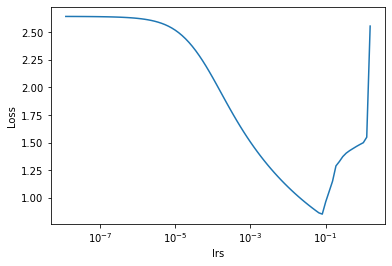

In [ ]:
#hide
random_seed(0)
#learn.freeze()
learn.lr_finder()

Epoch,train_loss,valid_loss,accuracy,precision,recall,f1_score,time
0,0.799041,0.876615,0.7154,0.727805,0.7154,0.711649,00:46
1,0.585704,0.741553,0.7575,0.763627,0.7575,0.753597,00:48
2,0.447472,0.659835,0.785,0.789852,0.785,0.783901,00:48
3,0.313291,0.715216,0.7869,0.793389,0.7869,0.786292,00:51
4,0.241612,0.719766,0.7974,0.799303,0.7974,0.796518,00:51


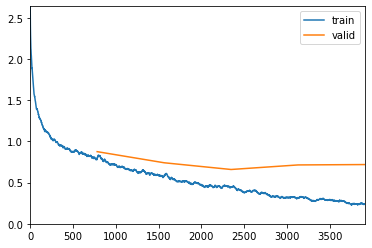

In [ ]:
random_seed(0)
learn.fit(5,1e-03,wd = 1e-04)

In [ ]:
t = learn.cbs[1].accumetric.target

In [ ]:
f = torch.cat((t))

In [ ]:
f.shape

torch.Size([10000])